## Generator of Evaluation QA Pairs

In [5]:
import datasets

In [6]:
amazon_product = datasets.load_dataset("milistu/AMAZON-Products-2023")
print(amazon_product)

DatasetDict({
    train: Dataset({
        features: ['parent_asin', 'date_first_available', 'title', 'description', 'filename', 'main_category', 'categories', 'store', 'average_rating', 'rating_number', 'price', 'features', 'details', 'embeddings', 'image', '__index_level_0__'],
        num_rows: 117243
    })
})


In [7]:
df = amazon_product["train"].to_pandas()
df.head()

,parent_asin,date_first_available,title,description,filename,main_category,categories,store,average_rating,rating_number,price,features,details,embeddings,image,__index_level_0__
0,B000044U2O,2023-04-29,Anomie & Bonhomie,Amazon.com\nFans of Scritti Politti's synth-po...,meta_Digital_Music,Digital Music,[],Scritti Politti Format: Audio CD,4.2,56.0,NaN,[],"{'Date First Available': 'April 29, 2023'}","[0.015389198, -0.009462837, 0.020776799, -0.01...",https://m.media-amazon.com/images/I/41T618NE88...,1
1,B0BT4CWWC9,2023-01-26,Sunshine On My Shoulders: The Best Of John Den...,"“Sunshine On My Shoulders” is a 2CD, 36-track ...",meta_Digital_Music,Digital Music,[],John Denver Format: Audio CD,4.7,502.0,19.98,[],{'Package Dimensions': '5.55 x 4.92 x 0.51 inc...,"[0.021719493, -0.034223344, 0.05114032, -0.006...",https://m.media-amazon.com/images/I/81bwkd6a3Q...,2
2,B0BS4L5LP6,2023-01-11,18 Greatest Hits of 38 Special,Track Listings: 1. Rockin' Into The Night 2. ...,meta_Digital_Music,Digital Music,[],38 Special (Contributor) Format: Audio CD,5.0,1.0,14.97,[],"{'Item Weight': '4 Ounces', 'Run time': '1 hou...","[0.004309814, 0.009167284, 0.009274434, -0.063...",https://m.media-amazon.com/images/I/91wPsEXtuE...,5
3,B0BSPBBP89,2023-01-20,The Gift [CD],Second studio album by the multi-million-selli...,meta_Digital_Music,Digital Music,[],Susan Boyle Format: Audio CD,4.8,34.0,12.99,[],{'Package Dimensions': '5.59 x 4.8 x 0.47 inch...,"[-0.0065331007, 0.012574269, -0.01417005, -0.0...",https://m.media-amazon.com/images/I/41fr0qCrCq...,12
4,B0BT1YG8MV,2023-01-20,ΤΗΕ ΒΟΟΤLΕG SΕRΙΕS VοΙ. ᛐ7 ᛐ996-ᛐ997 FRΑԌΜΕΝΤՏ...,"EU Edition 2CD,\nDISC ONE - TIME OUT OF MIND [...",meta_Digital_Music,Digital Music,[],ΒΟΒ DΥԼΑΝ (Contributor) Format: Audio CD,3.6,5.0,43.99,[],"{'Manufacturer': 'Columbia Records, Sony Music...","[-0.00026524643, -0.0143332025, 0.002644092, -...",https://m.media-amazon.com/images/I/61VgSSP6Ta...,14


<Axes: ylabel='main_category'>

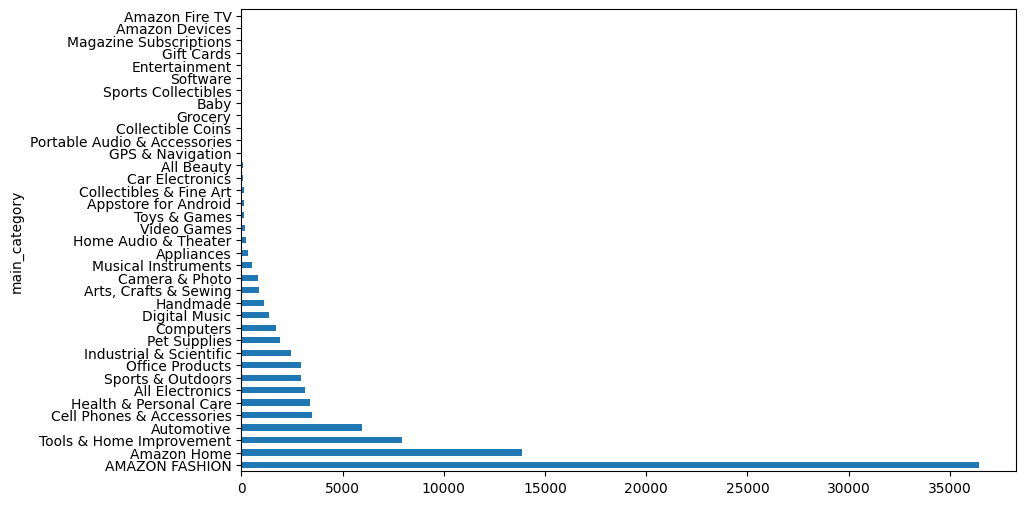

In [8]:
df['main_category'].value_counts().plot(kind='barh', figsize=(10, 6))

In [9]:
beauty_products = df[df['main_category'] == 'All Beauty']
beauty_products.shape

(65, 16)

In [11]:
import os
from dotenv import load_dotenv

if os.path.exists("private-config.env"):
    load_dotenv("private-config.env")
else:
    load_dotenv("config.env")

In [ ]:
from llama_index.core import Document
from llama_index.llms.openai import OpenAI
from llama_index.core.evaluation import DatasetGenerator

In [ ]:
cols = beauty_products.columns

docs = []
for i, row in beauty_products.iterrows():
    doctext = [f"{col}: {row[col]}" for col in cols]
    doctext = "\n".join(doctext)
    doc = Document(
        text=doctext,
        metadata={
            "description": row["description"],
            "title": row["title"],
        },
    )
    docs.append(doc)

In [14]:
llm = OpenAI(
    temperature=0,
    max_tokens=256,
    model="gpt-4o-mini",
    openai_api_key=os.getenv("OPENAI_API_KEY"),
)

In [39]:
dataset_generator = DatasetGenerator.from_documents(
    docs,
    num_questions_per_chunk=1,
    show_progress=True,
)

Parsing nodes: 100%|██████████| 65/65 [00:00<00:00, 1006.52it/s]
/Users/tptrix29/anaconda3/envs/graphrag/lib/python3.12/site-packages/llama_index/core/evaluation/dataset_generation.py:200: DeprecationWarning: Call to deprecated class DatasetGenerator. (Deprecated in favor of `RagDatasetGenerator` which should be used instead.)
  return cls(


In [40]:
qa_ds = await dataset_generator.agenerate_dataset_from_nodes()

100%|██████████| 5/5 [00:00<00:00,  5.49it/s]
/Users/tptrix29/anaconda3/envs/graphrag/lib/python3.12/site-packages/llama_index/core/evaluation/dataset_generation.py:296: DeprecationWarning: Call to deprecated class QueryResponseDataset. (Deprecated in favor of `LabelledRagDataset` which should be used instead.)
  return QueryResponseDataset(queries=queries, responses=responses_dict)


In [ ]:
len(qa_ds)

532

In [ ]:
qa_ds.save_json(os.environ["QR_DATA"])